# Проект по А/B-тестированию
### Оглавление
1. [Загрузка данных и подготовка их к анализу](#h1_1)
1. [Исследовательский анализ данных](#h1_2)
1. [Оценка результатов A/B-тестирования](#h1_3)
1. [Общий вывод](#h1_4)

### Описание проекта
Основная цель — провести оценку результатов A/B-теста. В распоряжении есть датасет с действиями пользователей, техническое задание и несколько вспомогательных датасетов. В рамках поставленной цели необходимо режить задачи:
* оценить корректность проведения теста;
* проанализировать результаты теста.

#### Изначальное ТЗ к A/B-тесту
* Название теста: recommender_system_test;
* Группы: А (контрольная), B (новая платёжная воронка);
* Дата запуска: 2020-12-07;
* Дата остановки набора новых пользователей: 2020-12-21;
* Дата остановки: 2021-01-04;
* Аудитория: 15% новых пользователей из региона EU;
* Назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
* Ожидаемое количество участников теста: 6000.
* Ожидаемый эффект: за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    * конверсии в просмотр карточек товаров — событие product_page
    * просмотры корзины — product_card
    * покупки — purchase.

    
### Общие функции для работы с данными

In [1]:
# Импорт необходимых библиотек
import pandas as pd
import datetime as dt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from plotly import graph_objects as go
import math as mth
import warnings
from scipy import stats as st

# Улучшение четкости изображения
%config InlineBackend.figure_format = 'retina'

#отключение предупреждений
warnings.filterwarnings('ignore')

def print_hist(data, title, x, y, bins_count=100, size=(10,5)):
    """Функция для вывода гистограммы на экран. Параметры:
        data - датафрейм или колонка
        bins_count - число корзин гистограммы
        size - размер рисунка
        title - заголовок гистограммы
        x - название оси абсцисс
        y - названи оси ординат
    """
    with plt.style.context('seaborn'):
        data.hist(bins = bins_count, figsize=size)
        plt.grid(True)
        plt.title(title)
        plt.xlabel(x)
        plt.ylabel(y)
        plt.show()
        
def print_plot(data, plot_kind, title, x, y, size=(10,5), annotate=True):
    """Функция для вывода графика на экран. Параметры:
        data - датафрейм или колонка
        bins_count - число корзин гистограммы
        size - размер рисунка
        title - заголовок гистограммы
        x - название оси абсцисс
        y - названи оси ординат
        annotate - опция для вывода над колонками долей от общего цисла (в процентах)
    """
    with plt.style.context('seaborn'):
        ax = data.plot(kind=plot_kind, stacked=False, figsize=size)
        plt.title(title)
        plt.xlabel(x)
        plt.ylabel(y)
        plt.xticks(rotation=0)
        if annotate == True:
            total = 0
            for p in ax.patches:
                total += p.get_height()
            for p in ax.patches:
                percentage = '{:.0f}%'.format(100 * p.get_height()/total)
                xl = p.get_x() + p.get_width()/2.
                yl = p.get_y() + p.get_height()
                ax.annotate(percentage, (xl, yl), xytext=(0, 3), textcoords='offset points', horizontalalignment='center')
        plt.show()
        

## 1. Загрузка данных и подготовка их к анализу <a class="anchor" id="h1_1"></a>

In [2]:
# Открытие файлов и создание датафреймов
try:
    marketing_events = pd.read_csv('/datasets/ab_project_marketing_events.csv')
except:
    marketing_events = pd.read_csv('ab_project_marketing_events.csv')
    
try:
    final_new_users = pd.read_csv('/datasets/final_ab_new_users.csv')
except:
    final_new_users = pd.read_csv('final_ab_new_users.csv')
           
try:
    final_events = pd.read_csv('/datasets/final_ab_events.csv')
except:
    final_events = pd.read_csv('final_ab_events.csv')
    
try:
    final_participants = pd.read_csv('/datasets/final_ab_participants.csv')
except:
    final_participants = pd.read_csv('final_ab_participants.csv')

Рассмотрим подробнее каждый набор данных.

#### Данные о маркетинговых событиях в 2020 году

In [3]:
marketing_events.info()
display(marketing_events)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
name         14 non-null object
regions      14 non-null object
start_dt     14 non-null object
finish_dt    14 non-null object
dtypes: object(4)
memory usage: 576.0+ bytes


,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


Приведем колонку `start_dt` и `finish_dt` к типу `date`:

In [4]:
marketing_events['start_dt'] = marketing_events['start_dt'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
marketing_events['finish_dt'] = marketing_events['finish_dt'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

#### Данные о пользователях, зарегистрировавшихся в интернет-магазине в период с 7 по 21 декабря 2020 года

In [5]:
final_new_users.info()
display(final_new_users)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
user_id       61733 non-null object
first_date    61733 non-null object
region        61733 non-null object
device        61733 non-null object
dtypes: object(4)
memory usage: 1.9+ MB


,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone
...,...,...,...,...
61728,1DB53B933257165D,2020-12-20,EU,Android
61729,538643EB4527ED03,2020-12-20,EU,Mac
61730,7ADEE837D5D8CBBD,2020-12-20,EU,PC
61731,1C7D23927835213F,2020-12-20,EU,iPhone


Приведем колонку `first_date` к типу `date`:

In [6]:
final_new_users['first_date'] = final_new_users['first_date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

Посмотрим, есть ли в датафрейме дубликаты:

In [7]:
print('Количество дублей в данных: {}'.format(final_new_users['user_id'].duplicated().sum()))

Количество дублей в данных: 0


#### Данные о событиях новых пользователей в период с 7 декабря 2020 по 4 января 2021 года

In [8]:
final_events.info()
display(final_events)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
user_id       440317 non-null object
event_dt      440317 non-null object
event_name    440317 non-null object
details       62740 non-null float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99
...,...,...,...,...
440312,245E85F65C358E08,2020-12-30 19:35:55,login,NaN
440313,9385A108F5A0A7A7,2020-12-30 10:54:15,login,NaN
440314,DB650B7559AC6EAC,2020-12-30 10:59:09,login,NaN
440315,F80C9BDDEA02E53C,2020-12-30 09:53:39,login,NaN


In [9]:
final_events['event_dt'] = final_events['event_dt'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

Проверим датафрейм на дубликаты:

In [10]:
print('Количество дублей в данных: {}'.format(final_events.duplicated().sum()))

Количество дублей в данных: 0


В колонке `details` имеются пустые значения. Но это нормально, т.к. в нее записывается необязательная дополнительная информация. Она некритичная с точки зрения понимания, какой пользователь, когда и какое действие совершил.

#### Данные о событиях новых пользователей в период с 7 декабря 2020 по 4 января 2021 года

In [11]:
final_participants.info()
display(final_participants)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
user_id    18268 non-null object
group      18268 non-null object
ab_test    18268 non-null object
dtypes: object(3)
memory usage: 428.3+ KB


,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test
...,...,...,...
18263,1D302F8688B91781,B,interface_eu_test
18264,3DE51B726983B657,A,interface_eu_test
18265,F501F79D332BE86C,A,interface_eu_test
18266,63FBE257B05F2245,A,interface_eu_test


Проверим датафрейм на дубликаты:

In [12]:
print('Количество дублей в данных: {}'.format(final_participants['user_id'].duplicated().sum()))

Количество дублей в данных: 1602


### Выводы по шагу 1
В результате предобработки выполнено следующее:
* Данные из файлов загружены в датафреймы.
* Колонки с датами приведены к типу date.
* Дублей в данных не найдены.
* В данных о событиях имеются пустые значения в колонке `details`. Но это некритичная информация с точки зрения понимания, какой пользователь, когда и какое действие совершил. Поэтому пропуски не были удалены.

## 2. Исследовательский анализ данных <a class="anchor" id="h1_2"></a>
Рассмотрим подробнее каждый набор данных.

#### Данные о маркетинговых событиях в 2020 году
Выведем маркетинговые события в наглядном виде.

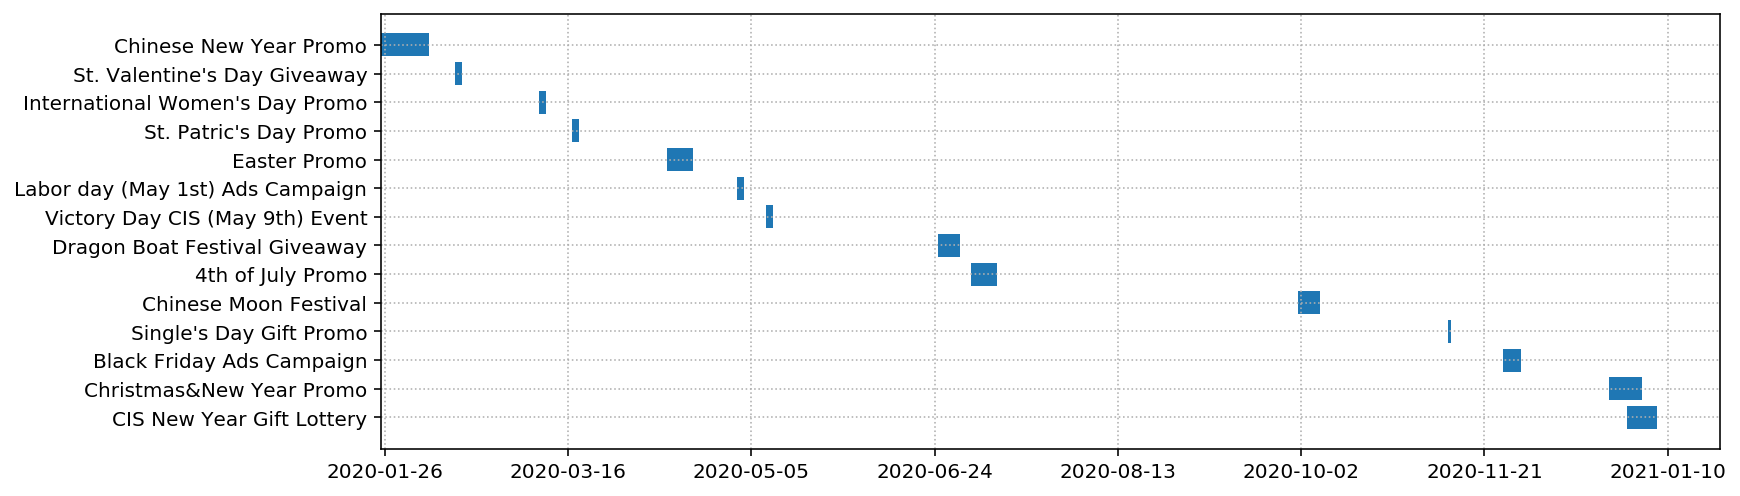

In [13]:
# сортировка датасета
marketing_events = marketing_events.sort_values(by='start_dt', ascending=False)

begin = marketing_events['start_dt'].to_numpy()
end =   marketing_events['finish_dt'].to_numpy()
event = marketing_events['name'].to_numpy()

plt.figure(figsize=(12,4))
plt.grid(True, linestyle=':')
plt.barh(range(len(begin)),  end-begin, left=begin)

plt.yticks(range(len(begin)), event)

# Форматирование даты на оси x
dtFmt = mdates.DateFormatter('%Y-%m-%d') # определение формата даты
plt.gca().xaxis.set_major_formatter(dtFmt) # применение формата к оси x

plt.show()

Видно, что на период проведения A/B-теста приходится две маркитинговых кампании:

In [14]:
marketing_events.query('finish_dt >= 20201207')

,name,regions,start_dt,finish_dt
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03


При оценке результатов тестирования мы будем учитывать только пользователей из региона EU, а они встречается в кампании "Christmas&New Year Promo". При проведении маркетинговых кампаний поведение пользователей сильно меняется.

Но проблема еще и в том, что конец года - не лучшее время для проведения тестирования. Даже без специальных кампаний поведение пользователей меняется в это время. Поэтому результат A/B-тестирования может дать совершенно другой результат, чем в обычное время.

#### Данные о новых пользователях
Покажем распределение новых пользователей по регионам:

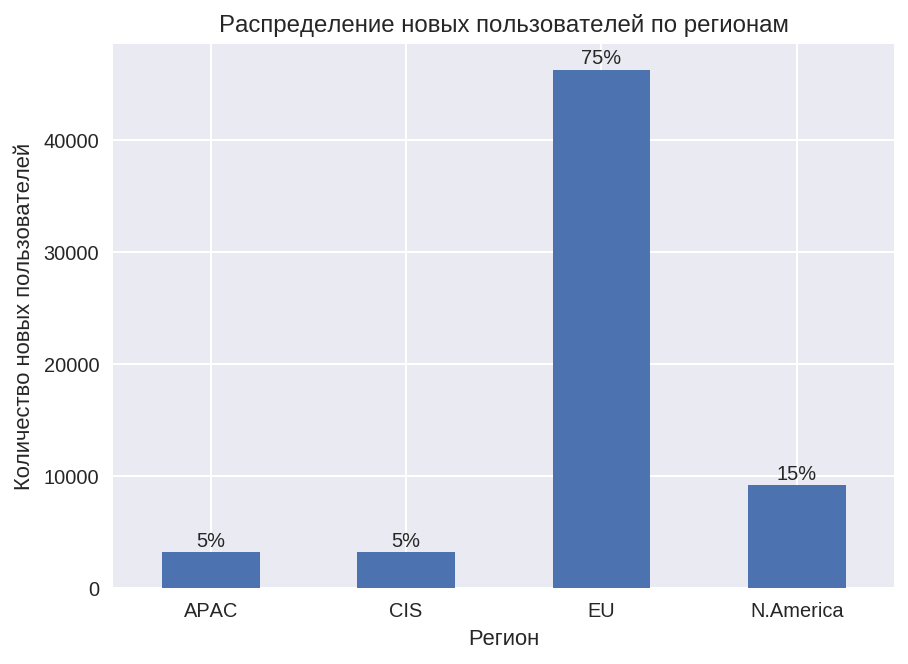

In [15]:
print_plot(final_new_users.groupby('region')['user_id'].agg('count'), 'bar', 'Распределение новых пользователей по регионам', 'Регион','Количество новых пользователей', (7,5))

Исключим из пользователей всех, кроме пользователей из региона EU:

In [16]:
final_new_users =  final_new_users[final_new_users['region'] == 'EU']

Теперь рассмотрим подробнее дату регистрации новых пользователей.

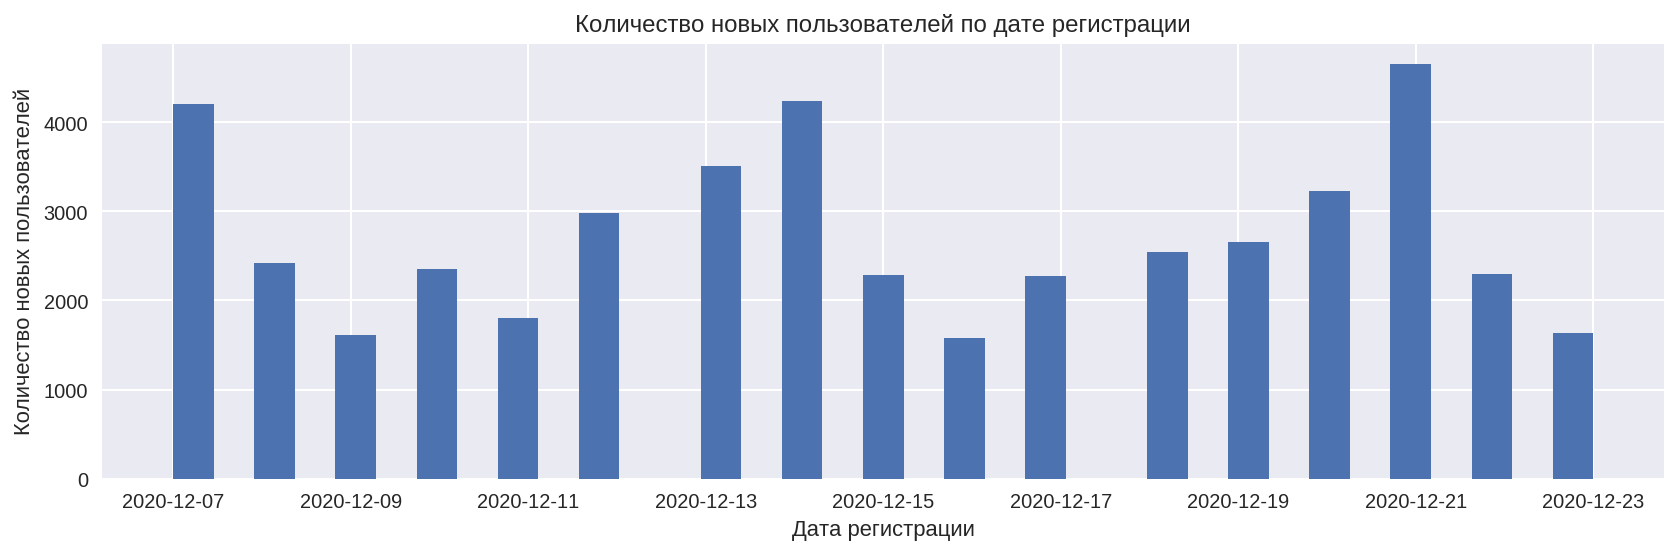

In [17]:
print_hist(final_new_users['first_date'], 'Количество новых пользователей по дате регистрации', 'Дата регистрации','Количество новых пользователей', 35, (14,4))

В датасете новые пользователи датируются, начиная с 2020-12-07, что соответствует ТЗ.
Но там также написано, что дата остановки набора новых пользователей 2020-12-21. В датасет же попали пользователи, зарегистрировшиеся по 2020-12-21. Таким образом, необходим удалить всех новых пользователей после этой даты.

In [18]:
final_new_users = final_new_users[final_new_users['first_date'] < dt.datetime(2020, 12, 21, 0, 0)]

#### Данные об участниках
Посмотрим, как изначально распределены участники по разным типам тестов и группам:

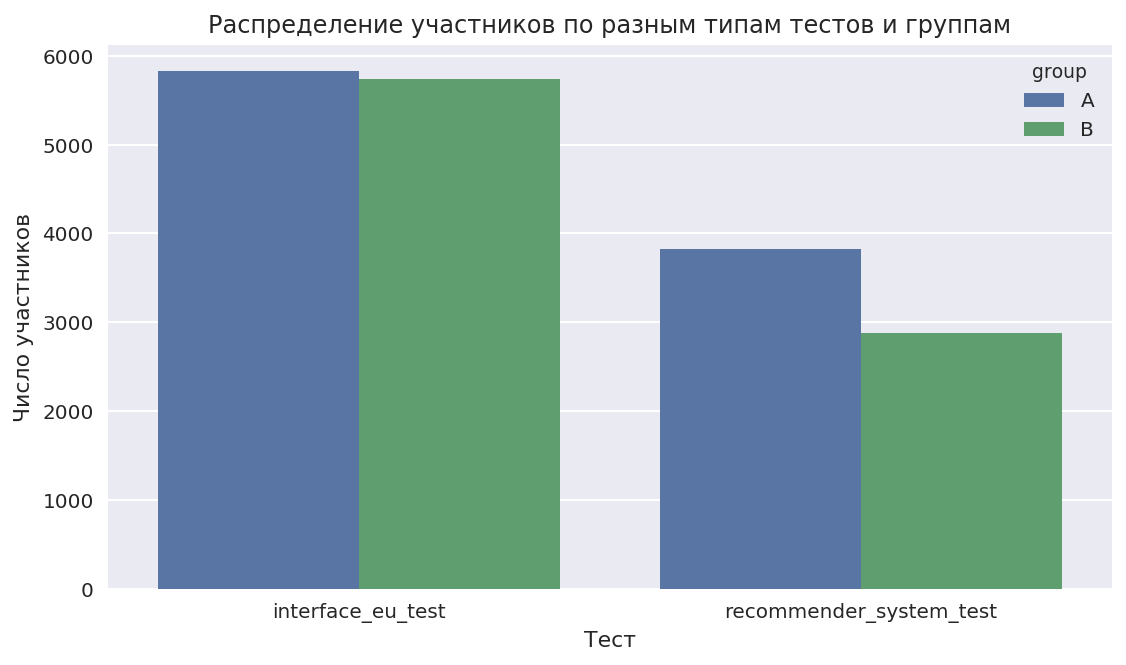

In [19]:
participants_stat = final_participants.groupby(['group','ab_test'])[['user_id']].nunique().reset_index().rename(columns={'user_id':'users_count'})

# Построение диаграммы
plt.figure(figsize=(9,5))
with plt.style.context('seaborn'):
    ax = sns.barplot(x='ab_test', y='users_count', hue='group', data=participants_stat)
plt.title('Распределение участников по разным типам тестов и группам')
plt.xlabel('Тест')
plt.ylabel('Число участников')    
plt.show()

В рассматриваемом нами тесте (`recommender_system_test`) набралось чуть более 6000 участников, как и заявлено в ТЗ. Но данные между группами А и B для распределены не в равных долях. У каждого пользователя должен быть равный шанс получить ту или иную версию, что в данном случае не выполняется.

Поскольку в данных имеется информация еще по одному тесту, то необходимо проверить пересечение участников между двумя тестами:

In [20]:
intersectUsers = np.intersect1d(
    final_participants.query('ab_test == "recommender_system_test"')['user_id'].unique(), 
    final_participants.query('ab_test == "interface_eu_test"')['user_id'].unique())
print('Количество пересечений между участниками между разными тестами:', len(intersectUsers))

Количество пересечений между участниками между разными тестами: 1602


Исключим из данных по участникам пересечения по пользователям, а также оставим только участников по тесту `recommender_system_test`:

In [21]:
final_participants = final_participants[np.logical_not(final_participants['user_id'].isin(intersectUsers))]
final_participants = final_participants.query('ab_test == "recommender_system_test"')

Также необходимо оставить среди участников только новых пользователей:

In [22]:
intersectUsers = np.intersect1d(
    final_participants['user_id'].unique(), 
    final_new_users['user_id'].unique())
print('Количество новых пользователей среди участников:', len(intersectUsers))
final_participants = final_participants[final_participants['user_id'].isin(intersectUsers)]

Количество новых пользователей среди участников: 4245


Таким образом, мы получили, что в данных с участниками уже меньше расчетных 6000 пользователей (как заявлено в ТЗ).

#### События новых пользователей

In [23]:
# Подсчет количества событий в первичных данных
events_total = len(final_events)
print('Всего событий в логе: ',events_total)

# Подсчет количества уникальных пользователей в первичных данных
users_total = final_events['user_id'].nunique()
print('Всего уникальных пользователй в логе: ',users_total)

print('Среднее количество событий, приходящихся на одного уникального пользователя: {:.0f}'.format(len(final_events)/final_events['user_id'].nunique()))

Всего событий в логе:  440317
Всего уникальных пользователй в логе:  58703
Среднее количество событий, приходящихся на одного уникального пользователя: 8


Рассмотрим подробнее время событий.

count                  440317
unique                 267268
top       2020-12-23 02:37:24
freq                       10
first     2020-12-07 00:00:33
last      2020-12-30 23:36:33
Name: event_dt, dtype: object


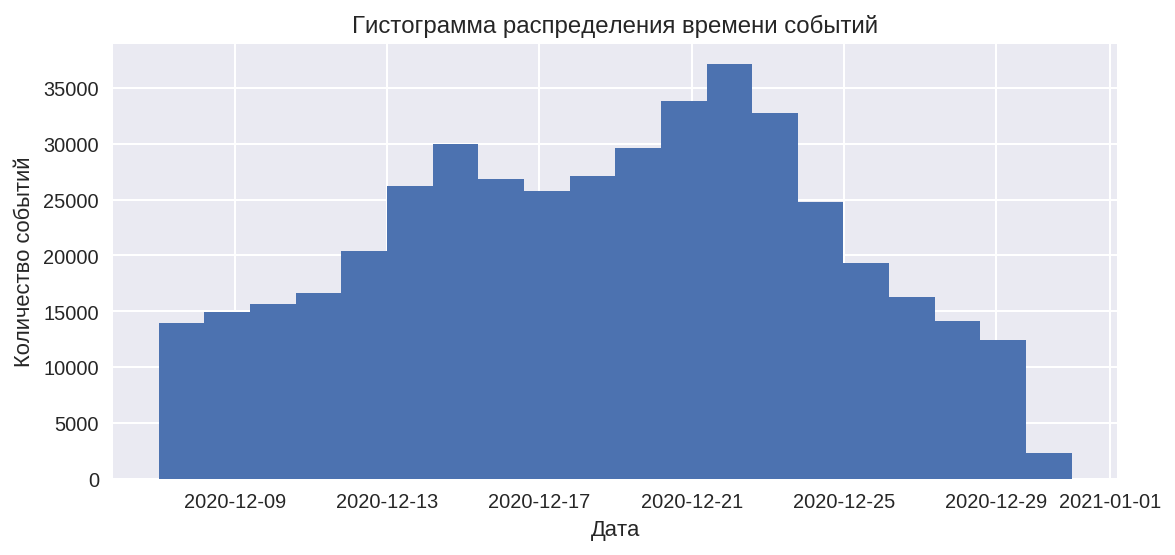

In [24]:
print(final_events['event_dt'].describe())
print_hist(final_events['event_dt'], 'Гистограмма распределения времени событий', 'Дата','Количество событий', 20, (9,4))

По гистограмме можно заметить , что перед празднованием католического Рождества (что актуально для рассматриваемого региона - EU) в данных о событиях имеется большой всплеск активности пользователей.

По описанию данных и гистограмме видно, что последние записи о событиях заканчиваются 30 декабря, а не 7 января. Выясним более точное время:

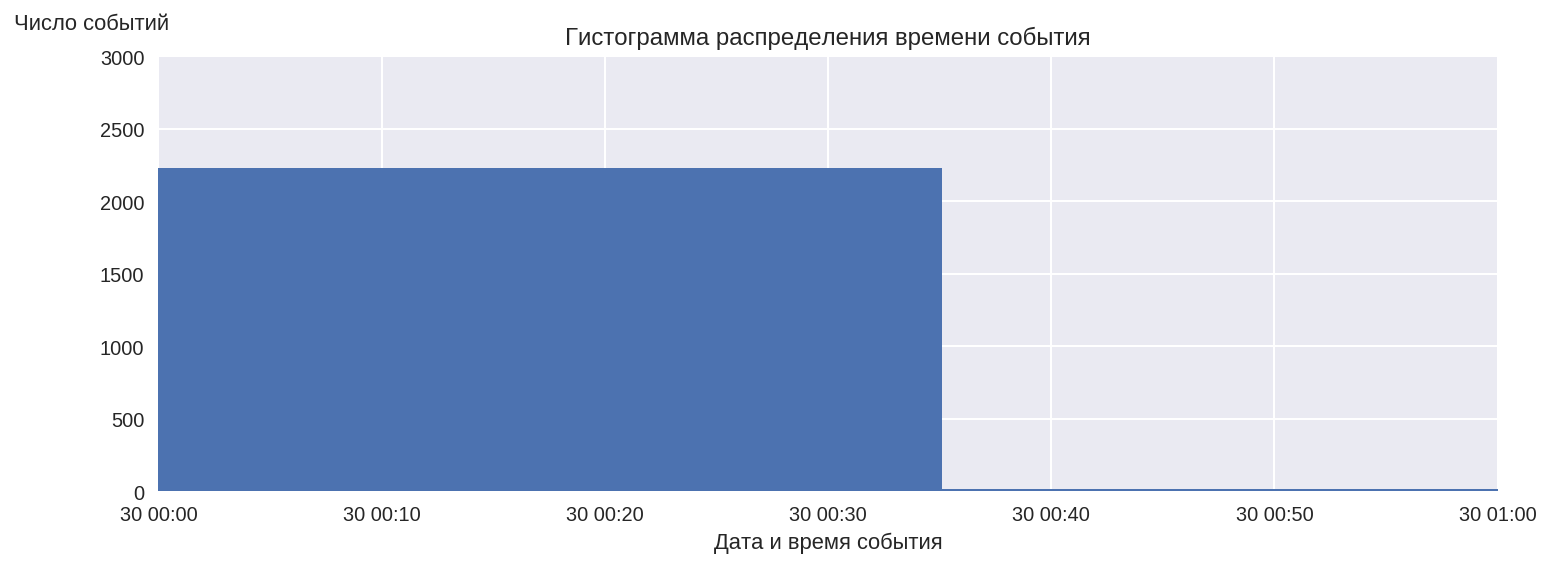

In [25]:
plt.figure(figsize=(12,4))
with plt.style.context('seaborn'):
    final_events['event_dt'].hist(bins=100)
    plt.title('Гистограмма распределения времени события')
    plt.ylabel('Число событий', rotation=0, position = (0,1.05))
    plt.xlabel('Дата и время события')
    plt.xlim(left=dt.datetime(2020, 12, 30, 0, 0), right=dt.datetime(2020, 12, 30, 1, 0))
    plt.ylim(top=3000)
    plt.show()

По уточненной гистограмме видно, что по факту тестирование завершилось в `00:35 30.12.2020`.
Удалим из датафрейма все события после этого времени:

In [26]:
final_events = final_events[final_events['event_dt'] < dt.datetime(2020, 12, 30, 0, 35)]

Оставим в данных о событиях отфильтрованных выше участников, а также объединим датафрейм с событиями с данными о новых пользователях.

In [27]:
final_events = final_events.merge(final_participants, left_on=['user_id'], right_on=['user_id'])
final_events = final_events.merge(final_new_users, left_on=['user_id'], right_on=['user_id'])

Посмотрим, как распределились пользователи по платформам:

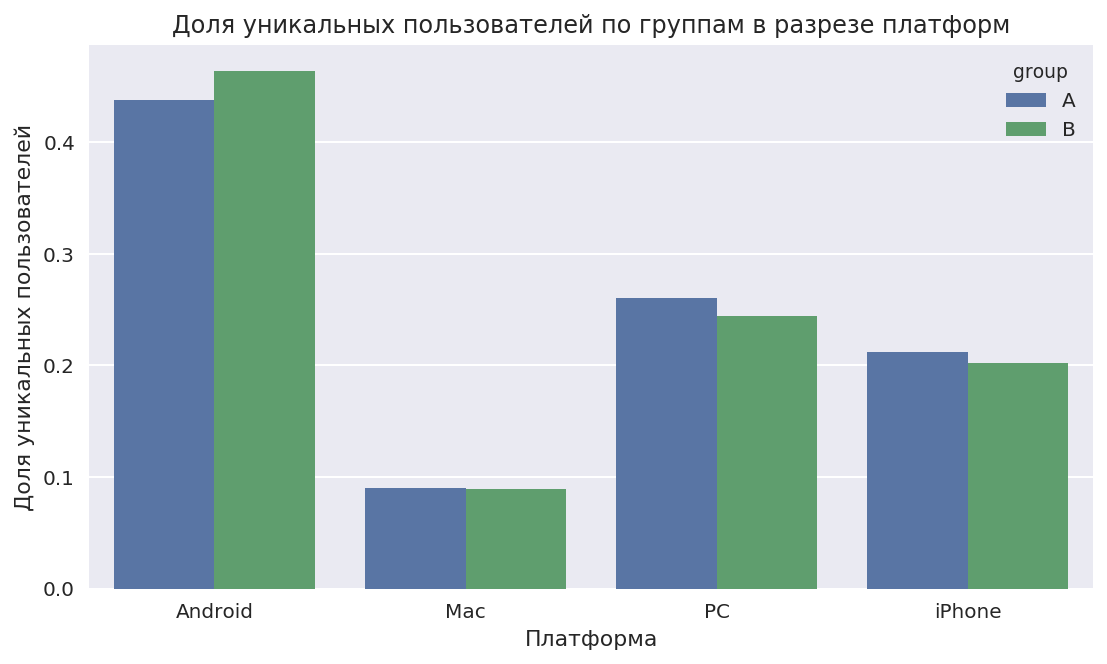

In [28]:
# Расчет распределения пользователй по платформам:
devices_stat = final_events.groupby(['group','device'])[['user_id']].nunique().reset_index().rename(columns={'user_id':'users_count'})
exp_stat = final_events.groupby('group')[['user_id']].nunique().reset_index().rename(columns={'user_id':'total'})
devices_stat = devices_stat.merge(exp_stat, left_on=['group'], right_on=['group'])
devices_stat['share'] = devices_stat['users_count'] / devices_stat['total']

# Построение диаграммы
plt.figure(figsize=(9,5))
with plt.style.context('seaborn'):
    ax = sns.barplot(x='device', y='share', hue='group', data=devices_stat)
plt.title('Доля уникальных пользователей по группам в разрезе платформ')
plt.xlabel('Платформа')
plt.ylabel('Доля уникальных пользователей')    
plt.show()

В эксперименте участвовали пользователи из четырех различных платформ. Доли пользователей распределились по платформам примерно одинаково для двух групп.

Теперь посмотрим, какие имеются события в данных:

In [29]:
final_events['event_name'].unique()

array(['purchase', 'product_cart', 'login', 'product_page'], dtype=object)

Посчитаем, сколько уникальных пользователей совершали каждое из этих событий, а также долю пользователей, которые хоть раз совершали событие. И выведем полученный результат в виде воронки.

In [30]:
# Подсчет количества уникальных пользователей для каждого типа события
events_by_users = final_events.groupby('event_name')[['user_id']].nunique().reset_index().rename(columns={'user_id':'users_count'})

# Сортировка записей для удобного показа в таблице и корректного отображения на диаграмме с воронкой
events_by_users = events_by_users.sort_values(by='users_count', ascending=False)

# Построение воронки
fig = go.Figure(go.Funnel(
    y = events_by_users['event_name'],
    x = events_by_users['users_count'],
    textinfo = "value+percent previous+percent initial",
    opacity = 0.65
    ))
fig.show() 

По воронке видны следующие особенности: 
   * конверсии на шагах `product_cart'` и `purchase` равны между собой.
   * по факту в тестировании принимало участие еще меньше пользователей, чем оказалось в таблице с участниками - чуть более 2000.

Построим воронку событий в разрезе групп тестирования:

In [31]:
# Подсчет количества уникальных пользователей по каждой экспериментальной группе:
exp_stat = final_events.groupby('group')[['user_id']].nunique().reset_index().rename(columns={'user_id':'users_count'})

exp_by_events = final_events.groupby(['group','event_name'])[['user_id']].nunique().reset_index().rename(columns={'user_id':'users_count'})

# Расставим последовательность в шагах
exp_by_events['event_order'] = 1
exp_by_events.loc[exp_by_events.event_name=='product_page','event_order'] = 2
exp_by_events.loc[exp_by_events.event_name=='product_cart','event_order'] = 3
exp_by_events.loc[exp_by_events.event_name=='purchase','event_order'] = 4
exp_by_events.loc[exp_by_events.event_name=='login','previous_event'] = 'all_users'
exp_by_events.loc[exp_by_events.event_name=='product_page','previous_event'] = 'login'
exp_by_events.loc[exp_by_events.event_name=='product_cart','previous_event'] = 'product_page'
exp_by_events.loc[exp_by_events.event_name=='purchase','previous_event'] = 'product_cart'
exp_by_events['previous_event'] = exp_by_events['previous_event'].fillna('')

exp_stat['event_name'] = 'all_users'
# Объединение с таблицей с общим количеством пользователей
exp_by_events = exp_by_events.sort_values(by=['group','event_order'], ascending=True).reset_index(drop=True)

exp_by_events['previous_event'] = exp_by_events['previous_event'].fillna('')

exp_by_events

,group,event_name,users_count,event_order,previous_event
0,A,login,1651,1,all_users
1,A,product_page,1072,2,login
2,A,product_cart,514,3,product_page
3,A,purchase,517,4,product_cart
4,B,login,593,1,all_users
5,B,product_page,330,2,login
6,B,product_cart,170,3,product_page
7,B,purchase,167,4,product_cart


In [32]:
groups=["A","B"]

fig = go.Figure()

for group in groups:
    fig.add_trace(go.Funnel(
        name = group,
        y = exp_by_events.query('group==@group')['event_name'],
        x = exp_by_events.query('group==@group')['users_count'],
        textinfo = "value+percent previous+percent initial",
        opacity = 0.8))

fig.show() 

По данной воронке видно, что
* Разница между числом участников разных групп еще больше увеличилась после удаления старых и пересекающихся пользователей. 
* Выборка уникальных пользователей заметно сократилась, особенно по группе B.
* В группе A до шага покупки дошло больше пользователей, чем до корзины. Это можно объяснить:
    * либо технической ошибкой при сборе данных, 
    * либо особенностями функционала системы (например, имеется возможность покупки в один клик - минуя корзину).

In [33]:
# Подсчет количества событий в первичных данных
events_total = len(final_events)
print('Всего событий в логе: ',events_total)

# Подсчет количества уникальных пользователей в первичных данных
users_total = final_events['user_id'].nunique()
print('Всего уникальных пользователй в логе: ',users_total)

print('Среднее количество событий, приходящихся на одного уникального пользователя: {:.0f}'.format(len(final_events)/final_events['user_id'].nunique()))

Всего событий в логе:  15320
Всего уникальных пользователй в логе:  2244
Среднее количество событий, приходящихся на одного уникального пользователя: 7


Подсчитаем количество уникальных пользователей для каждой группы.

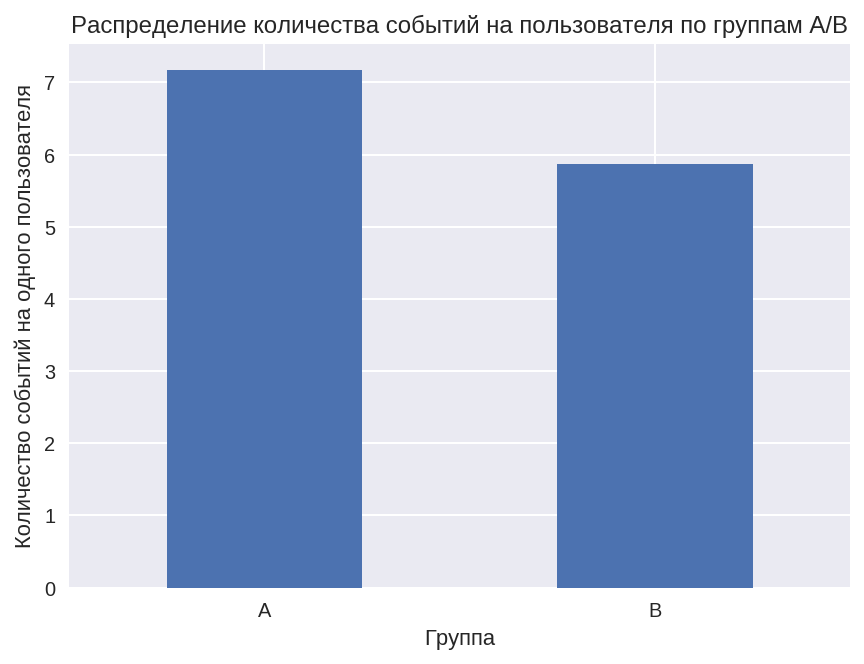

In [34]:
events_by_groups = final_events.groupby('group')[['user_id']].nunique().reset_index().rename(columns={'user_id':'unique_users'})
events_by_groups_total = final_events.groupby('group')[['user_id']].agg('count').reset_index().rename(columns={'user_id':'total_events'})
events_by_groups = events_by_groups.merge(events_by_groups_total, left_on=['group'], right_on=['group'])
events_by_groups ['events_by_user'] = events_by_groups['total_events'] / events_by_groups['unique_users']
print_plot(events_by_groups.groupby('group')['events_by_user'].agg('sum'), 'bar', 'Распределение количества событий на пользователя по группам A/B', 'Группа','Количество событий на одного пользователя', (7,5), False)

По полученной диаграмме видно заметное отличие количества событий на одного пользователя по группам A/B.

### Выводы по шагу 2
В ходе исследовательского анализа данных были обнаружены следующие особенности в данных:
1. Для тестирования выбрано не очень подходящее время:
    * На период проведения тестирования приходится одна маркетинговая кампания. При проведении маркетинговых кампаний поведение пользователей сильно меняется.
    * Даже без специальных кампаний поведение пользователей меняется в конце года. Перед празднованием католического Рождества (что актуально для рассматриваемого региона - EU) в данных о событиях видет большой всплеск активности пользователей.
    
    Таким образом, результат A/B-тестирования может дать совершенно другой результат, чем в обычное время.
1. В данных с новыми пользователями присутствовала информация о новых пользователях. Также имелись новые пользователи, зарегистрированные до даты остановки набора.
1. Участники рассматриваемого теста изначально распределены между группами A и B не поровну. Это говорит о том, что пользователи видели версии A и B не в случайном порядке.
1. Между группами А и B рассматриваемого теста не обнаружено пересечения по пользователям. Но есть пересечения между разными тестами по участникам тестов. Также среди участников тести были старые пользователи. После удаления пересекающихся участников и старых пользователей осталось только 2/3 участников теста.
1. Тестирование завершено 30.12.2020, а не 4.01.2021, как предполагалось в ТЗ.
1. В эксперименте участвовали пользователи из четырех различных платформ. Доли пользователей распределились по платформам примерно одинаково для двух групп.
1. После объединения отфильтрованных данных с участниками с данными о событиях оказалось, что в тесте по факту участвовала 1/3 пользователей от изначально заявленного в ТЗ. Также разница между числом участников разных групп еще больше увеличилась.
1. При исследовании воронки оказалось, что в группе A до шага покупки дошло больше пользователей, чем до корзины. Это можно объяснить:
   * либо технической ошибкой при сборе данных,
   * либо особенностями функционала системы (например, имеется возможность покупки в один клик - минуя корзину)
1. Количество событий на одного пользователя заметно отличается между группами.

Таким образом, ввиду большого количества проблем в данных можно сделать вывод, что тест был проведен некорректно.

## 3. Оценка результатов A/B-тестирования<a class="anchor" id="h1_3"></a>

Проверим для каждого событий, будет ли отличие между экспериментальными группами статистически достоверным.

Сформулируем нулевую и альтернативную гипотезы:

**Н0**: Доли уникальных пользователей по событию для сравниваемых групп равны.

**Н1**: Доли уникальных пользователей по событию для сравниваемых групп отличаются.

Проверим статистическую разницу долей z-критерием:

In [35]:
# Создание списка событий
events_list = ['product_page', 'product_cart', 'purchase']

# successes_array - массив с количеством пользователей, которые успешно сработало рассматриваемое события
# trials_array - массив с общим количеством пользователей, дошедших до рассматриваемого события
# alpha - критический уровень статистической значимости
# Функця чувствительна к порядку значений в массивах successes и trials. Поэтому важно убедиться, что значения по каждой экспериментальной группе расставлены в одинаковом порядке
def z_test(experiments, alpha):
    result = pd.DataFrame(columns=['group_1','group_2','event','previous_event','rel_diff','alpha','p_value','null_hyp'])
    # Проход по всем событиям воронки продаж
    for event in events_list:
        # Определение предыдущего события
        previous_event = exp_by_events.query('group==@experiments & event_name==@event')['previous_event'].iloc[0]

        # Задание массива количества успешных событий
        successes = np.array(exp_by_events.query('group==@experiments & event_name==@event')['users_count'])
        
        # Задание массива общего количества событий
        trials = np.array(exp_by_events.query('group==@experiments & event_name=="login"')['users_count'])

        # пропорция успехов в первой группе:
        p1 = successes[0]/trials[0]

        # пропорция успехов во второй группе:
        p2 = successes[1]/trials[1]
        
        # расчет относительной разницы между группами
        rel_diff = (p2 / p1 - 1) * 100

        # пропорция успехов в комбинированном датасете:
        p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

        # разница пропорций в датасетах
        difference = p1 - p2

        # считаем статистику в ст.отклонениях стандартного нормального распределения
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

        # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
        distr = st.norm(0, 1)

        p_value = (1 - distr.cdf(abs(z_value))) * 2  
        
        #
        if (p_value < alpha):
            null_hyp = False
        else:
            null_hyp = True
        
        result = result.append({
            'group_1': experiments[0],
            'group_2': experiments[1],
            'event': event,
            'previous_event': previous_event,
            'rel_diff': rel_diff,
            'alpha': alpha, 
            'p_value': p_value, 
            'null_hyp': null_hyp}, ignore_index=True)
    return result

display(z_test(["A","B"],0.05))

,group_1,group_2,event,previous_event,rel_diff,alpha,p_value,null_hyp
0,A,B,product_page,login,-14.293939,0.05,0.000062,False
1,A,B,product_cart,product_page,-7.917271,0.05,0.263378,True
2,A,B,purchase,product_cart,-10.067160,0.05,0.152588,True


### Выводы по шагу 3
Проверка результата A/B-тестирования показала, что:
   * Есть значимая разница между долями уникальных посетителей контрольных групп А и B для события отображения страницы с товаром.
   * По всем остальным событиям нет статистически значимого различия долей между первой контрольной группой А и группой B. Т.е. отклонения в конверсии просмотра корзины (7%) и покупки (10%) могли оказаться случайными.

## 4. Общий вывод
Оценка результатов A/B-тестирования показала, что изначально заявленное улучшение метрик конверсии в 10% не было достигнуто.

Но в целом тестирование было проведено некорректно ввиду следующих проблем:
   * Некорректно выбрано время проведения теста:
        * во время тестирования проводилась маркетинговая кампания в рассматриваемом регионе;
        * тестирование проводилось в новогодние праздники.
   * Изначальное разбиение на выборки А и В выполнено не в правильной пропорции.
   * Не все этапы воронки являются обязательными, либо есть технические ошибки при логировании событий.
   * Тестирование завершено раньше, чем как предполагалось в ТЗ.